### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

# Clase 1: rho1, etiqueta = 1
a_test = np.random.uniform(0, 1, int(n_test/2))
for a in a_test:
    rho, label = ρ1(a)
    data_test.append((rho, label))

# Clase 2: rho2, etiqueta = 2
b_test = np.random.uniform(0, 1, int(n_test/2))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 50
data = []

# Familia 1 → usa ρ1(a), etiqueta = 1
a_values = np.random.uniform(0, 1, int(n_samples/2))
for a in a_values:
    rho, label = ρ1(a)  # rho es matriz 4x4, label = 1
    data.append((rho, label))

# Familia 2 → usa ρ2(b), etiqueta = 2
b_values = np.random.uniform(0, 1, int(n_samples/2))
for b in b_values:
    rho, label = ρ2(b)  # rho es matriz 4x4, label = 2
    data.append((rho, label))

# Mezclar y dividir: 80% entrenamiento, 20% validación
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 40  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 1000
batch_size = int(len(data_train)*0.2)
val_batch_size=int(0.2*batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 100
min_delta = 1e-6
best_val_loss = float('inf')
patience_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
test_suc_history = []
test_err_history = []
test_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):
    
    # Seleccionar un batch aleatorio de data_train
    batch = random.sample(data_train, batch_size)
    
    # Paso de entrenamiento con el batch
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)
    
    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)




    # Early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"⏹️ Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        break

    # Evaluación en train y test
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_test, err_test, inc_test = evaluate_model(params, data_test)

    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    test_suc_history.append(suc_test)
    test_err_history.append(err_test)
    test_inc_history.append(inc_test)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"test_suc={suc_test:.3f}, test_err={err_test:.3f}, test_inc={inc_test:.3f}")

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
print(f"  Éxito promedio     = {suc_test:.4f}")
print(f"  Error promedio     = {err_test:.4f}")
print(f"  Inconcluso promedio = {inc_test:.4f}")




Entrenando:   0%|          | 0/1000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/1000 [06:58<116:13:00, 418.80s/it]

Entrenando:   0%|          | 2/1000 [13:57<116:04:43, 418.72s/it]

Entrenando:   0%|          | 3/1000 [20:56<116:03:45, 419.08s/it]

Entrenando:   0%|          | 4/1000 [27:55<115:55:28, 419.00s/it]

Entrenando:   0%|          | 5/1000 [34:55<115:49:33, 419.07s/it]

Entrenando:   1%|          | 6/1000 [41:53<115:40:28, 418.94s/it]

Entrenando:   1%|          | 7/1000 [48:51<115:29:46, 418.72s/it]

Entrenando:   1%|          | 8/1000 [55:50<115:19:52, 418.54s/it]

Entrenando:   1%|          | 9/1000 [1:02:48<115:11:43, 418.47s/it]

Entrenando:   1%|          | 10/1000 [1:09:47<115:09:34, 418.76s/it]

Entrenando:   1%|          | 11/1000 [1:16:47<115:08:16, 419.11s/it]

Entrenando:   1%|          | 12/1000 [1:23:47<115:02:28, 419.18s/it]

Entrenando:   1%|▏         | 13/1000 [1:30:44<114:45:43, 418.59s/it]

Entrenando:   1%|▏         | 14/1000 [1:37:41<114:31:50, 418.17s/it]

Entrenando:   2%|▏         | 15/1000 [1:44:41<114:32:10, 418.61s/it]

Entrenando:   2%|▏         | 16/1000 [1:51:41<114:32:51, 419.08s/it]

Entrenando:   2%|▏         | 17/1000 [1:58:39<114:19:16, 418.67s/it]

Entrenando:   2%|▏         | 18/1000 [2:05:37<114:10:22, 418.56s/it]

Entrenando:   2%|▏         | 19/1000 [2:12:36<114:04:57, 418.65s/it]

Entrenando:   2%|▏         | 20/1000 [2:19:34<113:54:07, 418.42s/it]

Entrenando:   2%|▏         | 21/1000 [2:26:32<113:45:20, 418.30s/it]

Entrenando:   2%|▏         | 22/1000 [2:33:30<113:36:33, 418.19s/it]

Entrenando:   2%|▏         | 23/1000 [2:40:28<113:32:20, 418.36s/it]

Entrenando:   2%|▏         | 24/1000 [2:47:27<113:26:39, 418.44s/it]

Entrenando:   2%|▎         | 25/1000 [2:54:25<113:20:05, 418.47s/it]

Entrenando:   3%|▎         | 26/1000 [3:01:26<113:23:59, 419.14s/it]

Entrenando:   3%|▎         | 27/1000 [3:08:25<113:13:22, 418.91s/it]

Entrenando:   3%|▎         | 28/1000 [3:15:22<113:00:01, 418.52s/it]

Entrenando:   3%|▎         | 29/1000 [3:22:21<112:54:25, 418.61s/it]

Entrenando:   3%|▎         | 30/1000 [3:29:20<112:48:41, 418.68s/it]

Entrenando:   3%|▎         | 31/1000 [3:36:19<112:42:43, 418.74s/it]

Entrenando:   3%|▎         | 32/1000 [3:43:17<112:33:17, 418.59s/it]

Entrenando:   3%|▎         | 33/1000 [3:50:16<112:28:00, 418.70s/it]

Entrenando:   3%|▎         | 34/1000 [3:57:15<112:21:37, 418.73s/it]

Entrenando:   4%|▎         | 35/1000 [4:04:13<112:12:20, 418.59s/it]

Entrenando:   4%|▎         | 36/1000 [4:11:12<112:08:29, 418.79s/it]

Entrenando:   4%|▎         | 37/1000 [4:18:12<112:08:07, 419.20s/it]

Entrenando:   4%|▍         | 38/1000 [4:25:11<111:58:30, 419.03s/it]

Entrenando:   4%|▍         | 39/1000 [4:32:10<111:52:42, 419.11s/it]

Entrenando:   4%|▍         | 40/1000 [4:39:09<111:45:59, 419.12s/it]

Entrenando:   4%|▍         | 41/1000 [4:46:08<111:34:14, 418.83s/it]

Entrenando:   4%|▍         | 42/1000 [4:53:06<111:25:08, 418.69s/it]

Entrenando:   4%|▍         | 43/1000 [5:00:43<114:20:37, 430.13s/it]

Entrenando:   4%|▍         | 44/1000 [5:08:19<116:20:01, 438.08s/it]

Entrenando:   4%|▍         | 45/1000 [5:15:55<117:38:32, 443.47s/it]

Entrenando:   5%|▍         | 46/1000 [5:23:32<118:35:19, 447.50s/it]

Entrenando:   5%|▍         | 47/1000 [5:31:09<119:10:10, 450.17s/it]

Entrenando:   5%|▍         | 48/1000 [5:38:20<117:34:20, 444.60s/it]

Entrenando:   5%|▍         | 49/1000 [5:45:20<115:27:57, 437.10s/it]

Entrenando:   5%|▌         | 50/1000 [5:52:19<113:55:56, 431.74s/it]

Iter  50: train_loss=7.5238, val_loss=15.1465, train_suc=0.439, train_err=0.262, train_inc=0.299 | test_suc=0.401, test_err=0.277, test_inc=0.321


Entrenando:   5%|▌         | 51/1000 [5:59:17<112:44:06, 427.66s/it]

Entrenando:   5%|▌         | 52/1000 [6:06:16<111:55:45, 425.05s/it]

Entrenando:   5%|▌         | 53/1000 [6:13:16<111:21:41, 423.34s/it]

Entrenando:   5%|▌         | 54/1000 [6:20:15<110:53:34, 422.00s/it]

Entrenando:   6%|▌         | 55/1000 [6:27:14<110:35:09, 421.28s/it]

Entrenando:   6%|▌         | 56/1000 [6:34:13<110:16:11, 420.52s/it]

Entrenando:   6%|▌         | 57/1000 [6:41:12<110:02:13, 420.08s/it]

Entrenando:   6%|▌         | 58/1000 [6:48:11<109:51:52, 419.86s/it]

Entrenando:   6%|▌         | 59/1000 [6:55:09<109:36:26, 419.33s/it]

Entrenando:   6%|▌         | 60/1000 [7:02:08<109:24:56, 419.04s/it]

Entrenando:   6%|▌         | 61/1000 [7:09:07<109:18:54, 419.10s/it]

Entrenando:   6%|▌         | 62/1000 [7:16:06<109:11:26, 419.07s/it]

Entrenando:   6%|▋         | 63/1000 [7:23:04<108:58:52, 418.71s/it]

Entrenando:   6%|▋         | 64/1000 [7:30:04<108:56:13, 418.99s/it]

Entrenando:   6%|▋         | 65/1000 [7:37:02<108:45:28, 418.75s/it]

Entrenando:   7%|▋         | 66/1000 [7:44:00<108:35:46, 418.57s/it]

Entrenando:   7%|▋         | 67/1000 [7:50:59<108:32:49, 418.83s/it]

Entrenando:   7%|▋         | 68/1000 [7:57:59<108:28:26, 419.00s/it]

Entrenando:   7%|▋         | 69/1000 [8:04:58<108:21:54, 419.03s/it]

Entrenando:   7%|▋         | 70/1000 [8:11:56<108:08:53, 418.64s/it]

Entrenando:   7%|▋         | 71/1000 [8:18:55<108:04:01, 418.77s/it]

Entrenando:   7%|▋         | 72/1000 [8:25:54<108:02:08, 419.10s/it]

Entrenando:   7%|▋         | 73/1000 [8:32:55<108:00:05, 419.42s/it]

Entrenando:   7%|▋         | 74/1000 [8:39:53<107:49:36, 419.20s/it]

Entrenando:   8%|▊         | 75/1000 [8:46:52<107:42:19, 419.18s/it]

Entrenando:   8%|▊         | 76/1000 [8:54:09<108:54:10, 424.30s/it]

Entrenando:   8%|▊         | 77/1000 [9:01:07<108:17:16, 422.36s/it]

Entrenando:   8%|▊         | 78/1000 [9:08:05<107:50:47, 421.09s/it]

Entrenando:   8%|▊         | 79/1000 [9:15:03<107:29:47, 420.18s/it]

Entrenando:   8%|▊         | 80/1000 [9:22:03<107:22:14, 420.15s/it]

Entrenando:   8%|▊         | 81/1000 [9:29:02<107:09:54, 419.80s/it]

Entrenando:   8%|▊         | 82/1000 [9:36:00<106:57:47, 419.46s/it]

Entrenando:   8%|▊         | 83/1000 [9:42:59<106:48:33, 419.32s/it]

Entrenando:   8%|▊         | 84/1000 [9:50:00<106:46:28, 419.64s/it]

Entrenando:   8%|▊         | 85/1000 [9:56:58<106:34:34, 419.32s/it]

Entrenando:   9%|▊         | 86/1000 [10:03:58<106:31:10, 419.55s/it]

Entrenando:   9%|▊         | 87/1000 [10:10:58<106:26:00, 419.67s/it]

Entrenando:   9%|▉         | 88/1000 [10:17:58<106:18:30, 419.64s/it]

Entrenando:   9%|▉         | 89/1000 [10:24:57<106:07:44, 419.39s/it]

Entrenando:   9%|▉         | 90/1000 [10:31:55<105:54:54, 419.00s/it]

Entrenando:   9%|▉         | 91/1000 [10:38:54<105:47:59, 419.01s/it]

Entrenando:   9%|▉         | 92/1000 [10:45:53<105:39:29, 418.91s/it]

Entrenando:   9%|▉         | 93/1000 [10:52:51<105:28:02, 418.61s/it]

Entrenando:   9%|▉         | 94/1000 [10:59:51<105:27:27, 419.04s/it]

Entrenando:  10%|▉         | 95/1000 [11:06:50<105:23:27, 419.23s/it]

Entrenando:  10%|▉         | 96/1000 [11:13:49<105:15:42, 419.18s/it]

Entrenando:  10%|▉         | 97/1000 [11:20:50<105:14:52, 419.59s/it]

Entrenando:  10%|▉         | 98/1000 [11:27:49<105:07:57, 419.60s/it]

Entrenando:  10%|▉         | 99/1000 [11:34:49<105:00:08, 419.54s/it]

Entrenando:  10%|█         | 100/1000 [11:41:49<104:55:00, 419.67s/it]

Iter 100: train_loss=8.3655, val_loss=11.0962, train_suc=0.455, train_err=0.209, train_inc=0.336 | test_suc=0.415, test_err=0.212, test_inc=0.373


Entrenando:  10%|█         | 101/1000 [11:48:47<104:40:30, 419.17s/it]

Entrenando:  10%|█         | 102/1000 [11:55:46<104:31:48, 419.05s/it]

Entrenando:  10%|█         | 103/1000 [12:02:45<104:28:05, 419.27s/it]

Entrenando:  10%|█         | 104/1000 [12:09:44<104:17:31, 419.03s/it]

Entrenando:  10%|█         | 105/1000 [12:16:44<104:13:52, 419.25s/it]

Entrenando:  11%|█         | 106/1000 [12:23:43<104:06:29, 419.23s/it]

Entrenando:  11%|█         | 107/1000 [12:30:42<104:00:05, 419.27s/it]

Entrenando:  11%|█         | 108/1000 [12:37:40<103:45:57, 418.79s/it]

Entrenando:  11%|█         | 109/1000 [12:44:38<103:37:47, 418.71s/it]

Entrenando:  11%|█         | 110/1000 [12:51:36<103:27:52, 418.51s/it]

Entrenando:  11%|█         | 111/1000 [12:59:00<105:11:35, 425.98s/it]

Entrenando:  11%|█         | 112/1000 [13:06:36<107:20:09, 435.15s/it]

Entrenando:  11%|█▏        | 113/1000 [13:14:13<108:47:00, 441.51s/it]

Entrenando:  11%|█▏        | 114/1000 [13:21:49<109:43:50, 445.86s/it]

Entrenando:  12%|█▏        | 115/1000 [13:29:25<110:21:05, 448.89s/it]

Entrenando:  12%|█▏        | 116/1000 [13:37:01<110:46:14, 451.10s/it]

Entrenando:  12%|█▏        | 117/1000 [13:44:07<108:50:19, 443.74s/it]

Entrenando:  12%|█▏        | 118/1000 [13:51:07<106:56:14, 436.48s/it]

Entrenando:  12%|█▏        | 119/1000 [13:58:07<105:35:52, 431.50s/it]

Entrenando:  12%|█▏        | 120/1000 [14:05:05<104:28:40, 427.41s/it]

Entrenando:  12%|█▏        | 121/1000 [14:12:03<103:40:57, 424.64s/it]

Entrenando:  12%|█▏        | 122/1000 [14:19:02<103:11:29, 423.11s/it]

Entrenando:  12%|█▏        | 123/1000 [14:26:00<102:40:44, 421.49s/it]

Entrenando:  12%|█▏        | 124/1000 [14:33:00<102:24:12, 420.84s/it]

Entrenando:  12%|█▎        | 125/1000 [14:39:58<102:07:45, 420.19s/it]

Entrenando:  13%|█▎        | 126/1000 [14:46:56<101:52:25, 419.62s/it]

Entrenando:  13%|█▎        | 127/1000 [14:53:55<101:40:01, 419.25s/it]

Entrenando:  13%|█▎        | 128/1000 [15:00:53<101:28:11, 418.91s/it]

Entrenando:  13%|█▎        | 129/1000 [15:07:53<101:24:02, 419.11s/it]

Entrenando:  13%|█▎        | 130/1000 [15:14:51<101:15:06, 418.97s/it]

Entrenando:  13%|█▎        | 131/1000 [15:21:50<101:05:52, 418.82s/it]

Entrenando:  13%|█▎        | 132/1000 [15:28:49<100:59:47, 418.88s/it]

Entrenando:  13%|█▎        | 133/1000 [15:35:47<100:50:25, 418.71s/it]

Entrenando:  13%|█▎        | 134/1000 [15:43:15<102:48:32, 427.38s/it]

Entrenando:  14%|█▎        | 135/1000 [15:50:32<103:25:40, 430.45s/it]

Entrenando:  14%|█▎        | 136/1000 [15:57:32<102:30:36, 427.13s/it]

Entrenando:  14%|█▎        | 137/1000 [16:04:30<101:45:44, 424.50s/it]

Entrenando:  14%|█▍        | 138/1000 [16:11:29<101:13:18, 422.74s/it]

Entrenando:  14%|█▍        | 139/1000 [16:18:27<100:48:41, 421.51s/it]

Entrenando:  14%|█▍        | 140/1000 [16:25:27<100:33:34, 420.95s/it]

Entrenando:  14%|█▍        | 141/1000 [16:32:26<100:19:12, 420.43s/it]

Entrenando:  14%|█▍        | 142/1000 [16:39:26<100:09:21, 420.23s/it]

Entrenando:  14%|█▍        | 143/1000 [16:46:25<99:58:00, 419.93s/it] 

Entrenando:  14%|█▍        | 144/1000 [16:53:24<99:48:20, 419.74s/it]

Entrenando:  14%|█▍        | 145/1000 [17:00:23<99:38:01, 419.51s/it]

Entrenando:  15%|█▍        | 146/1000 [17:07:22<99:26:33, 419.20s/it]

Entrenando:  15%|█▍        | 147/1000 [17:14:22<99:22:18, 419.39s/it]

Entrenando:  15%|█▍        | 148/1000 [17:21:21<99:15:13, 419.38s/it]

Entrenando:  15%|█▍        | 149/1000 [17:28:21<99:11:39, 419.62s/it]

Entrenando:  15%|█▌        | 150/1000 [17:35:22<99:08:31, 419.90s/it]

Iter 150: train_loss=7.9254, val_loss=8.3140, train_suc=0.537, train_err=0.177, train_inc=0.285 | test_suc=0.489, test_err=0.172, test_inc=0.338


Entrenando:  15%|█▌        | 151/1000 [17:42:22<99:01:20, 419.88s/it]

Entrenando:  15%|█▌        | 152/1000 [17:49:21<98:52:19, 419.74s/it]

Entrenando:  15%|█▌        | 153/1000 [17:56:20<98:40:27, 419.40s/it]

Entrenando:  15%|█▌        | 154/1000 [18:03:18<98:31:15, 419.24s/it]

Entrenando:  16%|█▌        | 155/1000 [18:10:17<98:21:36, 419.05s/it]

Entrenando:  16%|█▌        | 156/1000 [18:17:16<98:14:39, 419.05s/it]

Entrenando:  16%|█▌        | 157/1000 [18:24:14<98:03:48, 418.78s/it]

Entrenando:  16%|█▌        | 158/1000 [18:31:13<97:57:33, 418.83s/it]

Entrenando:  16%|█▌        | 159/1000 [18:38:13<97:56:23, 419.24s/it]

Entrenando:  16%|█▌        | 160/1000 [18:45:12<97:47:02, 419.07s/it]

Entrenando:  16%|█▌        | 161/1000 [18:52:11<97:39:31, 419.04s/it]

Entrenando:  16%|█▌        | 162/1000 [18:59:09<97:29:26, 418.82s/it]

Entrenando:  16%|█▋        | 163/1000 [19:06:08<97:22:43, 418.83s/it]

Entrenando:  16%|█▋        | 164/1000 [19:13:07<97:17:02, 418.93s/it]

Entrenando:  16%|█▋        | 165/1000 [19:20:07<97:12:29, 419.10s/it]

Entrenando:  17%|█▋        | 166/1000 [19:27:07<97:07:48, 419.27s/it]

Entrenando:  17%|█▋        | 167/1000 [19:34:06<97:01:08, 419.29s/it]

Entrenando:  17%|█▋        | 168/1000 [19:41:03<96:44:53, 418.62s/it]

Entrenando:  17%|█▋        | 169/1000 [19:48:03<96:43:24, 419.02s/it]

Entrenando:  17%|█▋        | 170/1000 [19:55:02<96:36:28, 419.02s/it]

Entrenando:  17%|█▋        | 171/1000 [20:02:02<96:32:50, 419.27s/it]

Entrenando:  17%|█▋        | 172/1000 [20:09:00<96:22:19, 419.01s/it]

Entrenando:  17%|█▋        | 173/1000 [20:15:58<96:10:12, 418.64s/it]

Entrenando:  17%|█▋        | 174/1000 [20:22:56<96:02:12, 418.56s/it]

Entrenando:  18%|█▊        | 175/1000 [20:29:56<95:57:54, 418.76s/it]

Entrenando:  18%|█▊        | 176/1000 [20:36:55<95:53:10, 418.92s/it]

Entrenando:  18%|█▊        | 177/1000 [20:43:55<95:49:13, 419.14s/it]

Entrenando:  18%|█▊        | 178/1000 [20:50:54<95:42:04, 419.13s/it]

Entrenando:  18%|█▊        | 179/1000 [20:57:52<95:30:07, 418.77s/it]

Entrenando:  18%|█▊        | 180/1000 [21:04:50<95:22:57, 418.75s/it]

Entrenando:  18%|█▊        | 181/1000 [21:11:49<95:16:57, 418.82s/it]

Entrenando:  18%|█▊        | 182/1000 [21:18:48<95:11:17, 418.92s/it]

Entrenando:  18%|█▊        | 183/1000 [21:25:47<95:03:50, 418.89s/it]

Entrenando:  18%|█▊        | 184/1000 [21:32:46<94:57:41, 418.95s/it]

Entrenando:  18%|█▊        | 185/1000 [21:39:45<94:49:18, 418.84s/it]

Entrenando:  19%|█▊        | 186/1000 [21:46:44<94:44:11, 418.98s/it]

Entrenando:  19%|█▊        | 187/1000 [21:53:43<94:34:38, 418.79s/it]

Entrenando:  19%|█▉        | 188/1000 [22:00:42<94:30:44, 419.02s/it]

Entrenando:  19%|█▉        | 189/1000 [22:07:41<94:24:45, 419.09s/it]

Entrenando:  19%|█▉        | 190/1000 [22:14:41<94:21:30, 419.37s/it]

Entrenando:  19%|█▉        | 191/1000 [22:21:41<94:14:20, 419.36s/it]

Entrenando:  19%|█▉        | 192/1000 [22:28:41<94:11:09, 419.64s/it]

Entrenando:  19%|█▉        | 193/1000 [22:35:39<93:59:21, 419.28s/it]

Entrenando:  19%|█▉        | 194/1000 [22:42:39<93:54:31, 419.44s/it]

Entrenando:  20%|█▉        | 195/1000 [22:49:39<93:47:18, 419.43s/it]

Entrenando:  20%|█▉        | 196/1000 [22:56:39<93:43:40, 419.68s/it]

Entrenando:  20%|█▉        | 197/1000 [23:03:39<93:37:35, 419.75s/it]

Entrenando:  20%|█▉        | 198/1000 [23:10:37<93:22:47, 419.16s/it]

Entrenando:  20%|█▉        | 199/1000 [23:17:35<93:11:20, 418.83s/it]

Entrenando:  20%|██        | 200/1000 [23:24:34<93:08:16, 419.12s/it]

Iter 200: train_loss=5.5551, val_loss=6.9970, train_suc=0.569, train_err=0.166, train_inc=0.265 | test_suc=0.518, test_err=0.156, test_inc=0.326


Entrenando:  20%|██        | 201/1000 [23:31:33<93:00:24, 419.05s/it]

Entrenando:  20%|██        | 202/1000 [23:38:31<92:48:04, 418.65s/it]

Entrenando:  20%|██        | 203/1000 [23:45:28<92:35:12, 418.21s/it]

Entrenando:  20%|██        | 204/1000 [23:52:27<92:30:22, 418.37s/it]

Entrenando:  20%|██        | 205/1000 [23:59:25<92:22:03, 418.27s/it]

Entrenando:  21%|██        | 206/1000 [24:06:25<92:21:15, 418.73s/it]

Entrenando:  21%|██        | 207/1000 [24:13:24<92:13:57, 418.71s/it]

Entrenando:  21%|██        | 208/1000 [24:20:24<92:12:05, 419.10s/it]

Entrenando:  21%|██        | 209/1000 [24:27:23<92:06:42, 419.22s/it]

Entrenando:  21%|██        | 210/1000 [24:34:22<92:00:25, 419.27s/it]

Entrenando:  21%|██        | 211/1000 [24:41:23<91:57:06, 419.55s/it]

Entrenando:  21%|██        | 212/1000 [24:48:22<91:47:43, 419.37s/it]

Entrenando:  21%|██▏       | 213/1000 [24:55:20<91:37:55, 419.16s/it]

Entrenando:  21%|██▏       | 214/1000 [25:02:20<91:34:31, 419.43s/it]

Entrenando:  22%|██▏       | 215/1000 [25:09:20<91:29:43, 419.60s/it]

Entrenando:  22%|██▏       | 216/1000 [25:16:19<91:20:52, 419.45s/it]

Entrenando:  22%|██▏       | 217/1000 [25:23:18<91:11:29, 419.27s/it]

Entrenando:  22%|██▏       | 218/1000 [25:30:18<91:05:38, 419.36s/it]

Entrenando:  22%|██▏       | 219/1000 [25:37:19<91:04:04, 419.77s/it]

Entrenando:  22%|██▏       | 220/1000 [25:44:18<90:56:24, 419.72s/it]

Entrenando:  22%|██▏       | 221/1000 [25:51:18<90:50:22, 419.80s/it]

Entrenando:  22%|██▏       | 222/1000 [25:58:17<90:37:46, 419.37s/it]

Entrenando:  22%|██▏       | 223/1000 [26:05:16<90:32:44, 419.52s/it]

Entrenando:  22%|██▏       | 224/1000 [26:12:15<90:23:15, 419.32s/it]

Entrenando:  22%|██▎       | 225/1000 [26:19:15<90:19:29, 419.57s/it]

Entrenando:  23%|██▎       | 226/1000 [26:26:14<90:08:46, 419.29s/it]

Entrenando:  23%|██▎       | 227/1000 [26:33:15<90:06:29, 419.65s/it]

Entrenando:  23%|██▎       | 228/1000 [26:40:13<89:55:08, 419.31s/it]

Entrenando:  23%|██▎       | 229/1000 [26:47:13<89:51:46, 419.59s/it]

Entrenando:  23%|██▎       | 230/1000 [26:54:12<89:42:59, 419.45s/it]

Entrenando:  23%|██▎       | 231/1000 [27:01:10<89:29:11, 418.92s/it]

Entrenando:  23%|██▎       | 232/1000 [27:08:09<89:21:48, 418.89s/it]

Entrenando:  23%|██▎       | 233/1000 [27:15:09<89:18:22, 419.17s/it]

Entrenando:  23%|██▎       | 234/1000 [27:22:07<89:09:04, 418.99s/it]

Entrenando:  24%|██▎       | 235/1000 [27:29:06<89:00:07, 418.83s/it]

Entrenando:  24%|██▎       | 236/1000 [27:36:05<88:54:15, 418.92s/it]

Entrenando:  24%|██▎       | 237/1000 [27:43:05<88:50:06, 419.14s/it]

Entrenando:  24%|██▍       | 238/1000 [27:50:05<88:47:19, 419.47s/it]

Entrenando:  24%|██▍       | 239/1000 [27:57:03<88:35:45, 419.11s/it]

Entrenando:  24%|██▍       | 240/1000 [28:04:02<88:29:07, 419.14s/it]

Entrenando:  24%|██▍       | 241/1000 [28:11:01<88:21:14, 419.07s/it]

Entrenando:  24%|██▍       | 242/1000 [28:18:00<88:14:50, 419.12s/it]

Entrenando:  24%|██▍       | 243/1000 [28:25:01<88:13:37, 419.57s/it]

Entrenando:  24%|██▍       | 244/1000 [28:31:59<88:01:17, 419.15s/it]

Entrenando:  24%|██▍       | 245/1000 [28:38:59<87:56:10, 419.30s/it]

Entrenando:  25%|██▍       | 246/1000 [28:45:59<87:51:21, 419.47s/it]

Entrenando:  25%|██▍       | 247/1000 [28:53:09<88:24:58, 422.71s/it]

Entrenando:  25%|██▍       | 248/1000 [29:00:46<90:26:45, 432.99s/it]

Entrenando:  25%|██▍       | 249/1000 [29:08:22<91:47:42, 440.03s/it]

Entrenando:  25%|██▌       | 250/1000 [29:15:58<92:40:26, 444.84s/it]

Iter 250: train_loss=4.0620, val_loss=6.3315, train_suc=0.585, train_err=0.157, train_inc=0.258 | test_suc=0.533, test_err=0.147, test_inc=0.320


Entrenando:  25%|██▌       | 251/1000 [29:23:35<93:15:23, 448.23s/it]

Entrenando:  25%|██▌       | 252/1000 [29:31:11<93:37:31, 450.60s/it]

Entrenando:  25%|██▌       | 253/1000 [29:38:47<93:50:59, 452.29s/it]

Entrenando:  25%|██▌       | 254/1000 [29:46:24<94:01:28, 453.74s/it]

Entrenando:  26%|██▌       | 255/1000 [29:54:01<94:05:47, 454.69s/it]

Entrenando:  26%|██▌       | 256/1000 [30:01:38<94:06:50, 455.39s/it]

Entrenando:  26%|██▌       | 257/1000 [30:09:16<94:08:11, 456.11s/it]

Entrenando:  26%|██▌       | 258/1000 [30:16:53<94:04:51, 456.46s/it]

Entrenando:  26%|██▌       | 259/1000 [30:24:31<94:01:06, 456.77s/it]

Entrenando:  26%|██▌       | 260/1000 [30:32:08<93:56:26, 457.01s/it]

Entrenando:  26%|██▌       | 261/1000 [30:39:45<93:46:48, 456.84s/it]

Entrenando:  26%|██▌       | 262/1000 [30:47:22<93:40:29, 456.95s/it]

Entrenando:  26%|██▋       | 263/1000 [30:54:59<93:33:00, 456.96s/it]

Entrenando:  26%|██▋       | 264/1000 [31:02:36<93:26:17, 457.03s/it]

Entrenando:  26%|██▋       | 265/1000 [31:09:34<90:55:07, 445.32s/it]

Entrenando:  27%|██▋       | 266/1000 [31:16:33<89:12:57, 437.57s/it]

Entrenando:  27%|██▋       | 267/1000 [31:23:34<88:01:40, 432.33s/it]

Entrenando:  27%|██▋       | 268/1000 [31:30:32<87:02:58, 428.11s/it]

Entrenando:  27%|██▋       | 269/1000 [31:37:32<86:26:01, 425.67s/it]

Entrenando:  27%|██▋       | 270/1000 [31:44:31<85:54:28, 423.65s/it]

Entrenando:  27%|██▋       | 271/1000 [31:51:31<85:34:13, 422.57s/it]

Entrenando:  27%|██▋       | 272/1000 [31:58:29<85:09:43, 421.13s/it]

Entrenando:  27%|██▋       | 273/1000 [32:05:26<84:49:29, 420.04s/it]

Entrenando:  27%|██▋       | 274/1000 [32:12:25<84:38:01, 419.67s/it]

Entrenando:  28%|██▊       | 275/1000 [32:19:24<84:27:31, 419.38s/it]

Entrenando:  28%|██▊       | 276/1000 [32:26:22<84:17:14, 419.11s/it]

Entrenando:  28%|██▊       | 277/1000 [32:33:20<84:05:09, 418.69s/it]

Entrenando:  28%|██▊       | 278/1000 [32:40:18<83:56:05, 418.51s/it]

Entrenando:  28%|██▊       | 279/1000 [32:47:18<83:54:54, 418.99s/it]

Entrenando:  28%|██▊       | 280/1000 [32:54:16<83:45:35, 418.80s/it]

Entrenando:  28%|██▊       | 281/1000 [33:01:16<83:41:59, 419.08s/it]

Entrenando:  28%|██▊       | 282/1000 [33:08:15<83:34:55, 419.07s/it]

Entrenando:  28%|██▊       | 283/1000 [33:15:14<83:28:03, 419.08s/it]

Entrenando:  28%|██▊       | 284/1000 [33:22:12<83:17:42, 418.80s/it]

Entrenando:  28%|██▊       | 285/1000 [33:29:11<83:09:01, 418.66s/it]

Entrenando:  29%|██▊       | 286/1000 [33:36:09<83:02:03, 418.66s/it]

Entrenando:  29%|██▊       | 287/1000 [33:43:09<82:57:01, 418.82s/it]

Entrenando:  29%|██▉       | 288/1000 [33:50:08<82:50:41, 418.88s/it]

Entrenando:  29%|██▉       | 289/1000 [33:57:07<82:46:03, 419.08s/it]

Entrenando:  29%|██▉       | 290/1000 [34:04:09<82:47:59, 419.83s/it]

Entrenando:  29%|██▉       | 291/1000 [34:11:07<82:36:39, 419.46s/it]

Entrenando:  29%|██▉       | 292/1000 [34:18:05<82:24:51, 419.06s/it]

Entrenando:  29%|██▉       | 293/1000 [34:25:04<82:15:23, 418.85s/it]

Entrenando:  29%|██▉       | 294/1000 [34:32:03<82:07:54, 418.80s/it]

Entrenando:  30%|██▉       | 295/1000 [34:39:01<81:59:11, 418.65s/it]

Entrenando:  30%|██▉       | 296/1000 [34:45:59<81:49:13, 418.40s/it]

Entrenando:  30%|██▉       | 297/1000 [34:52:57<81:40:38, 418.26s/it]

Entrenando:  30%|██▉       | 298/1000 [34:59:55<81:33:16, 418.23s/it]

Entrenando:  30%|██▉       | 299/1000 [35:06:55<81:32:14, 418.74s/it]

Entrenando:  30%|███       | 300/1000 [35:13:54<81:27:31, 418.93s/it]

Iter 300: train_loss=8.6172, val_loss=5.7493, train_suc=0.592, train_err=0.150, train_inc=0.257 | test_suc=0.541, test_err=0.139, test_inc=0.320


Entrenando:  30%|███       | 301/1000 [35:20:54<81:24:26, 419.27s/it]

Entrenando:  30%|███       | 302/1000 [35:27:53<81:16:57, 419.22s/it]

Entrenando:  30%|███       | 303/1000 [35:34:52<81:09:12, 419.16s/it]

Entrenando:  30%|███       | 304/1000 [35:41:55<81:14:57, 420.25s/it]

Entrenando:  30%|███       | 305/1000 [35:49:33<83:18:23, 431.52s/it]

Entrenando:  31%|███       | 306/1000 [35:57:09<84:37:30, 438.98s/it]

Entrenando:  31%|███       | 307/1000 [36:04:46<85:31:58, 444.33s/it]

Entrenando:  31%|███       | 308/1000 [36:12:23<86:07:27, 448.05s/it]

Entrenando:  31%|███       | 309/1000 [36:20:00<86:33:00, 450.91s/it]

Entrenando:  31%|███       | 310/1000 [36:27:00<84:37:49, 441.55s/it]

Entrenando:  31%|███       | 311/1000 [36:33:59<83:11:38, 434.69s/it]

Entrenando:  31%|███       | 312/1000 [36:40:58<82:10:11, 429.96s/it]

Entrenando:  31%|███▏      | 313/1000 [36:47:58<81:28:28, 426.94s/it]

Entrenando:  31%|███▏      | 314/1000 [36:54:55<80:49:37, 424.16s/it]

Entrenando:  32%|███▏      | 315/1000 [37:01:54<80:23:49, 422.52s/it]

Entrenando:  32%|███▏      | 316/1000 [37:08:54<80:09:21, 421.87s/it]

Entrenando:  32%|███▏      | 317/1000 [37:15:52<79:48:19, 420.64s/it]

Entrenando:  32%|███▏      | 318/1000 [37:22:51<79:35:44, 420.15s/it]

Entrenando:  32%|███▏      | 319/1000 [37:29:50<79:23:59, 419.74s/it]

Entrenando:  32%|███▏      | 320/1000 [37:36:48<79:12:02, 419.30s/it]

Entrenando:  32%|███▏      | 321/1000 [37:43:46<79:00:53, 418.93s/it]

Entrenando:  32%|███▏      | 322/1000 [37:50:45<78:53:21, 418.88s/it]

Entrenando:  32%|███▏      | 323/1000 [37:57:45<78:49:13, 419.13s/it]

Entrenando:  32%|███▏      | 324/1000 [38:04:45<78:46:25, 419.50s/it]

Entrenando:  32%|███▎      | 325/1000 [38:11:43<78:33:06, 418.94s/it]

Entrenando:  33%|███▎      | 326/1000 [38:18:41<78:25:31, 418.89s/it]

Entrenando:  33%|███▎      | 327/1000 [38:25:39<78:14:37, 418.54s/it]

Entrenando:  33%|███▎      | 328/1000 [38:32:38<78:07:31, 418.53s/it]

Entrenando:  33%|███▎      | 329/1000 [38:39:36<78:01:14, 418.59s/it]

Entrenando:  33%|███▎      | 330/1000 [38:46:35<77:54:00, 418.57s/it]

Entrenando:  33%|███▎      | 331/1000 [38:53:35<77:50:40, 418.89s/it]

Entrenando:  33%|███▎      | 332/1000 [39:00:33<77:42:13, 418.76s/it]

Entrenando:  33%|███▎      | 333/1000 [39:07:32<77:35:00, 418.74s/it]

Entrenando:  33%|███▎      | 334/1000 [39:14:32<77:32:53, 419.18s/it]

Entrenando:  34%|███▎      | 335/1000 [39:21:30<77:23:45, 418.99s/it]

Entrenando:  34%|███▎      | 336/1000 [39:28:29<77:15:49, 418.90s/it]

Entrenando:  34%|███▎      | 337/1000 [39:35:29<77:11:17, 419.12s/it]

Entrenando:  34%|███▍      | 338/1000 [39:42:28<77:04:02, 419.10s/it]

Entrenando:  34%|███▍      | 339/1000 [39:49:28<76:59:24, 419.31s/it]

Entrenando:  34%|███▍      | 340/1000 [39:56:27<76:51:41, 419.25s/it]

Entrenando:  34%|███▍      | 341/1000 [40:03:27<76:46:44, 419.43s/it]

Entrenando:  34%|███▍      | 342/1000 [40:10:25<76:36:36, 419.14s/it]

Entrenando:  34%|███▍      | 343/1000 [40:17:24<76:28:23, 419.03s/it]

Entrenando:  34%|███▍      | 344/1000 [40:24:23<76:20:24, 418.94s/it]

Entrenando:  34%|███▍      | 345/1000 [40:31:22<76:14:55, 419.08s/it]

Entrenando:  35%|███▍      | 346/1000 [40:38:22<76:11:50, 419.43s/it]

Entrenando:  35%|███▍      | 347/1000 [40:45:21<76:03:01, 419.27s/it]

Entrenando:  35%|███▍      | 348/1000 [40:52:19<75:52:57, 418.98s/it]

Entrenando:  35%|███▍      | 349/1000 [40:59:18<75:45:07, 418.91s/it]

Entrenando:  35%|███▌      | 350/1000 [41:06:18<75:39:58, 419.07s/it]

Iter 350: train_loss=4.8392, val_loss=6.0830, train_suc=0.605, train_err=0.147, train_inc=0.249 | test_suc=0.551, test_err=0.140, test_inc=0.309


Entrenando:  35%|███▌      | 351/1000 [41:13:16<75:29:14, 418.73s/it]

Entrenando:  35%|███▌      | 352/1000 [41:20:14<75:20:17, 418.54s/it]

Entrenando:  35%|███▌      | 353/1000 [41:27:13<75:15:33, 418.75s/it]

Entrenando:  35%|███▌      | 354/1000 [41:34:12<75:08:26, 418.74s/it]

Entrenando:  36%|███▌      | 355/1000 [41:41:10<74:59:54, 418.60s/it]

Entrenando:  36%|███▌      | 356/1000 [41:48:08<74:52:40, 418.57s/it]

Entrenando:  36%|███▌      | 357/1000 [41:55:06<74:42:39, 418.29s/it]

Entrenando:  36%|███▌      | 358/1000 [42:02:05<74:37:29, 418.46s/it]

Entrenando:  36%|███▌      | 359/1000 [42:09:02<74:27:41, 418.19s/it]

Entrenando:  36%|███▌      | 360/1000 [42:16:02<74:26:01, 418.69s/it]

Entrenando:  36%|███▌      | 361/1000 [42:23:02<74:21:15, 418.90s/it]

Entrenando:  36%|███▌      | 362/1000 [42:30:01<74:16:36, 419.12s/it]

Entrenando:  36%|███▋      | 363/1000 [42:37:01<74:10:53, 419.24s/it]

Entrenando:  36%|███▋      | 364/1000 [42:43:58<73:58:50, 418.76s/it]

Entrenando:  36%|███▋      | 365/1000 [42:50:57<73:52:36, 418.83s/it]

Entrenando:  37%|███▋      | 366/1000 [42:57:57<73:47:18, 418.99s/it]

Entrenando:  37%|███▋      | 367/1000 [43:04:56<73:39:39, 418.93s/it]

Entrenando:  37%|███▋      | 368/1000 [43:11:55<73:34:58, 419.14s/it]

Entrenando:  37%|███▋      | 369/1000 [43:18:54<73:27:47, 419.12s/it]

Entrenando:  37%|███▋      | 370/1000 [43:25:52<73:16:25, 418.71s/it]

Entrenando:  37%|███▋      | 371/1000 [43:32:51<73:11:34, 418.91s/it]

Entrenando:  37%|███▋      | 372/1000 [43:39:50<73:04:56, 418.94s/it]

Entrenando:  37%|███▋      | 373/1000 [43:46:49<72:57:36, 418.91s/it]

Entrenando:  37%|███▋      | 374/1000 [43:53:49<72:53:34, 419.19s/it]

Entrenando:  38%|███▊      | 375/1000 [44:00:48<72:45:10, 419.06s/it]

Entrenando:  38%|███▊      | 376/1000 [44:07:48<72:41:44, 419.40s/it]

Entrenando:  38%|███▊      | 377/1000 [44:14:48<72:35:34, 419.48s/it]

Entrenando:  38%|███▊      | 378/1000 [44:21:48<72:31:20, 419.74s/it]

Entrenando:  38%|███▊      | 379/1000 [44:28:48<72:25:03, 419.81s/it]

Entrenando:  38%|███▊      | 380/1000 [44:35:48<72:18:30, 419.86s/it]

Entrenando:  38%|███▊      | 381/1000 [44:42:46<72:04:15, 419.15s/it]

Entrenando:  38%|███▊      | 382/1000 [44:49:43<71:51:51, 418.63s/it]

Entrenando:  38%|███▊      | 383/1000 [44:56:41<71:44:12, 418.56s/it]

Entrenando:  38%|███▊      | 384/1000 [45:03:40<71:38:24, 418.68s/it]

Entrenando:  38%|███▊      | 385/1000 [45:10:39<71:33:00, 418.83s/it]

Entrenando:  39%|███▊      | 386/1000 [45:17:41<71:34:42, 419.68s/it]

Entrenando:  39%|███▊      | 387/1000 [45:24:40<71:26:25, 419.55s/it]

Entrenando:  39%|███▉      | 388/1000 [45:31:38<71:14:29, 419.07s/it]

Entrenando:  39%|███▉      | 389/1000 [45:38:38<71:09:04, 419.22s/it]

Entrenando:  39%|███▉      | 390/1000 [45:45:35<70:55:54, 418.61s/it]

Entrenando:  39%|███▉      | 391/1000 [45:52:35<70:52:05, 418.92s/it]

Entrenando:  39%|███▉      | 392/1000 [45:59:33<70:42:14, 418.64s/it]

Entrenando:  39%|███▉      | 393/1000 [46:06:31<70:34:56, 418.61s/it]

Entrenando:  39%|███▉      | 394/1000 [46:13:31<70:29:53, 418.80s/it]

Entrenando:  40%|███▉      | 395/1000 [46:20:30<70:23:47, 418.89s/it]

Entrenando:  40%|███▉      | 396/1000 [46:27:29<70:19:34, 419.16s/it]

Entrenando:  40%|███▉      | 397/1000 [46:34:29<70:13:25, 419.25s/it]

Entrenando:  40%|███▉      | 398/1000 [46:41:27<70:04:22, 419.04s/it]

Entrenando:  40%|███▉      | 399/1000 [46:48:25<69:54:13, 418.72s/it]

Entrenando:  40%|████      | 400/1000 [46:55:25<69:48:52, 418.89s/it]

Iter 400: train_loss=6.6993, val_loss=5.7462, train_suc=0.610, train_err=0.142, train_inc=0.248 | test_suc=0.556, test_err=0.135, test_inc=0.309


Entrenando:  40%|████      | 401/1000 [47:02:24<69:42:40, 418.97s/it]

Entrenando:  40%|████      | 402/1000 [47:09:22<69:34:23, 418.84s/it]

Entrenando:  40%|████      | 403/1000 [47:16:20<69:25:05, 418.60s/it]

Entrenando:  40%|████      | 404/1000 [47:23:19<69:19:31, 418.74s/it]

Entrenando:  40%|████      | 405/1000 [47:30:17<69:09:21, 418.42s/it]

Entrenando:  41%|████      | 406/1000 [47:37:14<68:58:23, 418.02s/it]

Entrenando:  41%|████      | 407/1000 [47:44:13<68:54:53, 418.37s/it]

Entrenando:  41%|████      | 408/1000 [47:51:12<68:49:28, 418.53s/it]

Entrenando:  41%|████      | 409/1000 [47:58:11<68:43:16, 418.61s/it]

Entrenando:  41%|████      | 410/1000 [48:05:10<68:36:20, 418.61s/it]

Entrenando:  41%|████      | 411/1000 [48:12:10<68:33:11, 419.00s/it]

Entrenando:  41%|████      | 412/1000 [48:19:08<68:25:34, 418.94s/it]

Entrenando:  41%|████▏     | 413/1000 [48:26:07<68:17:40, 418.84s/it]

Entrenando:  41%|████▏     | 414/1000 [48:33:05<68:08:51, 418.65s/it]

Entrenando:  42%|████▏     | 415/1000 [48:40:05<68:05:39, 419.04s/it]

Entrenando:  42%|████▏     | 416/1000 [48:47:05<68:02:00, 419.38s/it]

Entrenando:  42%|████▏     | 417/1000 [48:54:05<67:55:21, 419.42s/it]

Entrenando:  42%|████▏     | 418/1000 [49:01:04<67:46:04, 419.18s/it]

Entrenando:  42%|████▏     | 419/1000 [49:08:02<67:37:13, 418.99s/it]

Entrenando:  42%|████▏     | 420/1000 [49:15:01<67:29:33, 418.92s/it]

Entrenando:  42%|████▏     | 421/1000 [49:21:58<67:18:24, 418.49s/it]

Entrenando:  42%|████▏     | 422/1000 [49:28:58<67:14:25, 418.80s/it]

Entrenando:  42%|████▏     | 423/1000 [49:35:56<67:05:53, 418.64s/it]

Entrenando:  42%|████▏     | 424/1000 [49:42:56<67:02:06, 418.97s/it]

Entrenando:  42%|████▎     | 425/1000 [49:49:54<66:52:32, 418.70s/it]

Entrenando:  43%|████▎     | 426/1000 [49:56:53<66:45:58, 418.74s/it]

Entrenando:  43%|████▎     | 427/1000 [50:03:53<66:43:16, 419.19s/it]

Entrenando:  43%|████▎     | 428/1000 [50:10:49<66:28:23, 418.36s/it]

Entrenando:  43%|████▎     | 429/1000 [50:17:48<66:22:35, 418.49s/it]

Entrenando:  43%|████▎     | 430/1000 [50:24:47<66:16:06, 418.54s/it]

Entrenando:  43%|████▎     | 431/1000 [50:31:47<66:12:33, 418.90s/it]

Entrenando:  43%|████▎     | 432/1000 [50:38:44<66:02:47, 418.60s/it]

Entrenando:  43%|████▎     | 433/1000 [50:45:47<66:07:42, 419.86s/it]

Entrenando:  43%|████▎     | 434/1000 [50:52:46<65:57:22, 419.51s/it]

Entrenando:  44%|████▎     | 435/1000 [50:59:45<65:50:15, 419.50s/it]

Entrenando:  44%|████▎     | 436/1000 [51:06:44<65:41:13, 419.28s/it]

Entrenando:  44%|████▎     | 437/1000 [51:13:44<65:35:42, 419.44s/it]

Entrenando:  44%|████▍     | 438/1000 [51:20:43<65:27:03, 419.26s/it]

Entrenando:  44%|████▍     | 439/1000 [51:27:42<65:18:50, 419.13s/it]

Entrenando:  44%|████▍     | 440/1000 [51:34:40<65:10:00, 418.93s/it]

Entrenando:  44%|████▍     | 441/1000 [51:41:39<65:03:19, 418.96s/it]

Entrenando:  44%|████▍     | 442/1000 [51:48:39<64:57:39, 419.10s/it]

Entrenando:  44%|████▍     | 443/1000 [51:55:38<64:50:31, 419.09s/it]

Entrenando:  44%|████▍     | 444/1000 [52:02:36<64:41:18, 418.85s/it]

Entrenando:  44%|████▍     | 445/1000 [52:09:35<64:35:32, 418.98s/it]

Entrenando:  45%|████▍     | 446/1000 [52:16:35<64:29:46, 419.11s/it]

Entrenando:  45%|████▍     | 447/1000 [52:23:35<64:24:49, 419.33s/it]

Entrenando:  45%|████▍     | 448/1000 [52:30:33<64:15:59, 419.13s/it]

Entrenando:  45%|████▍     | 449/1000 [52:37:32<64:07:30, 418.97s/it]

Entrenando:  45%|████▌     | 450/1000 [52:44:30<63:57:20, 418.62s/it]

Iter 450: train_loss=4.2247, val_loss=5.5781, train_suc=0.611, train_err=0.141, train_inc=0.249 | test_suc=0.558, test_err=0.133, test_inc=0.309


Entrenando:  45%|████▌     | 451/1000 [52:51:28<63:49:25, 418.52s/it]

Entrenando:  45%|████▌     | 452/1000 [52:58:27<63:45:05, 418.81s/it]

Entrenando:  45%|████▌     | 453/1000 [53:05:30<63:47:33, 419.84s/it]

Entrenando:  45%|████▌     | 454/1000 [53:12:33<63:50:30, 420.94s/it]

Entrenando:  46%|████▌     | 455/1000 [53:20:10<65:20:18, 431.59s/it]

Entrenando:  46%|████▌     | 456/1000 [53:27:46<66:21:37, 439.15s/it]

Entrenando:  46%|████▌     | 457/1000 [53:35:23<67:01:51, 444.40s/it]

Entrenando:  46%|████▌     | 458/1000 [53:43:00<67:28:14, 448.14s/it]

Entrenando:  46%|████▌     | 459/1000 [53:50:25<67:13:26, 447.33s/it]

Entrenando:  46%|████▌     | 460/1000 [53:57:24<65:49:57, 438.88s/it]

Entrenando:  46%|████▌     | 461/1000 [54:04:24<64:51:18, 433.17s/it]

Entrenando:  46%|████▌     | 462/1000 [54:11:24<64:07:30, 429.09s/it]

Entrenando:  46%|████▋     | 463/1000 [54:18:24<63:36:11, 426.39s/it]

Entrenando:  46%|████▋     | 464/1000 [54:25:23<63:08:33, 424.09s/it]

Entrenando:  46%|████▋     | 465/1000 [54:32:22<62:47:42, 422.55s/it]

Entrenando:  47%|████▋     | 466/1000 [54:39:20<62:29:21, 421.28s/it]

Entrenando:  47%|████▋     | 467/1000 [54:46:18<62:13:46, 420.31s/it]

Entrenando:  47%|████▋     | 468/1000 [54:53:17<62:03:42, 419.97s/it]

Entrenando:  47%|████▋     | 469/1000 [55:00:17<61:57:35, 420.07s/it]

Entrenando:  47%|████▋     | 470/1000 [55:07:17<61:49:58, 420.00s/it]

Entrenando:  47%|████▋     | 471/1000 [55:14:15<61:38:12, 419.46s/it]

Entrenando:  47%|████▋     | 472/1000 [55:21:15<61:30:09, 419.34s/it]

Entrenando:  47%|████▋     | 473/1000 [55:28:14<61:22:25, 419.25s/it]

Entrenando:  47%|████▋     | 474/1000 [55:35:14<61:18:41, 419.62s/it]

Entrenando:  48%|████▊     | 475/1000 [55:42:14<61:11:19, 419.58s/it]

Entrenando:  48%|████▊     | 476/1000 [55:49:12<61:01:12, 419.22s/it]

Entrenando:  48%|████▊     | 477/1000 [55:56:12<60:56:47, 419.52s/it]

Entrenando:  48%|████▊     | 478/1000 [56:03:12<60:49:42, 419.51s/it]

Entrenando:  48%|████▊     | 479/1000 [56:10:12<60:45:54, 419.87s/it]

Entrenando:  48%|████▊     | 480/1000 [56:17:12<60:39:26, 419.94s/it]

Entrenando:  48%|████▊     | 481/1000 [56:24:12<60:31:26, 419.82s/it]

Entrenando:  48%|████▊     | 482/1000 [56:31:12<60:24:41, 419.85s/it]

Entrenando:  48%|████▊     | 483/1000 [56:38:10<60:14:13, 419.45s/it]

Entrenando:  48%|████▊     | 484/1000 [56:45:10<60:06:20, 419.34s/it]

Entrenando:  48%|████▊     | 485/1000 [56:52:08<59:58:06, 419.20s/it]

Entrenando:  49%|████▊     | 486/1000 [56:59:08<59:51:22, 419.23s/it]

Entrenando:  49%|████▊     | 487/1000 [57:06:06<59:42:42, 419.03s/it]

Entrenando:  49%|████▉     | 488/1000 [57:13:06<59:38:33, 419.36s/it]

Entrenando:  49%|████▉     | 489/1000 [57:20:06<59:31:20, 419.34s/it]

Entrenando:  49%|████▉     | 490/1000 [57:27:05<59:24:09, 419.31s/it]

Entrenando:  49%|████▉     | 491/1000 [57:34:03<59:13:17, 418.86s/it]

Entrenando:  49%|████▉     | 492/1000 [57:41:01<59:04:28, 418.64s/it]

Entrenando:  49%|████▉     | 493/1000 [57:48:02<59:03:18, 419.33s/it]

Entrenando:  49%|████▉     | 494/1000 [57:55:01<58:56:27, 419.34s/it]

Entrenando:  50%|████▉     | 495/1000 [58:02:01<58:49:50, 419.39s/it]

Entrenando:  50%|████▉     | 496/1000 [58:09:01<58:44:41, 419.61s/it]

Entrenando:  50%|████▉     | 497/1000 [58:16:00<58:36:49, 419.50s/it]

Entrenando:  50%|████▉     | 498/1000 [58:22:58<58:26:10, 419.07s/it]

Entrenando:  50%|████▉     | 499/1000 [58:29:57<58:18:56, 419.03s/it]

Entrenando:  50%|█████     | 500/1000 [58:36:56<58:11:12, 418.94s/it]

Iter 500: train_loss=5.4685, val_loss=5.7700, train_suc=0.615, train_err=0.140, train_inc=0.245 | test_suc=0.561, test_err=0.134, test_inc=0.304


Entrenando:  50%|█████     | 501/1000 [58:43:55<58:05:27, 419.09s/it]

Entrenando:  50%|█████     | 502/1000 [58:50:54<57:56:42, 418.88s/it]

Entrenando:  50%|█████     | 503/1000 [58:57:53<57:50:14, 418.94s/it]

Entrenando:  50%|█████     | 504/1000 [59:04:51<57:41:10, 418.69s/it]

Entrenando:  50%|█████     | 505/1000 [59:11:49<57:34:14, 418.70s/it]

Entrenando:  51%|█████     | 506/1000 [59:18:49<57:30:11, 419.05s/it]

Entrenando:  51%|█████     | 507/1000 [59:25:48<57:22:41, 418.99s/it]

Entrenando:  51%|█████     | 508/1000 [59:32:48<57:18:20, 419.31s/it]

Entrenando:  51%|█████     | 509/1000 [59:39:46<57:08:19, 418.94s/it]

Entrenando:  51%|█████     | 510/1000 [59:46:46<57:03:50, 419.25s/it]

Entrenando:  51%|█████     | 511/1000 [59:53:45<56:55:33, 419.09s/it]

Entrenando:  51%|█████     | 512/1000 [60:00:43<56:46:13, 418.80s/it]

Entrenando:  51%|█████▏    | 513/1000 [60:07:42<56:38:17, 418.68s/it]

Entrenando:  51%|█████▏    | 514/1000 [60:14:41<56:33:30, 418.95s/it]

Entrenando:  52%|█████▏    | 515/1000 [60:21:40<56:26:41, 418.97s/it]

Entrenando:  52%|█████▏    | 516/1000 [60:28:39<56:18:36, 418.84s/it]

Entrenando:  52%|█████▏    | 517/1000 [60:35:37<56:10:54, 418.75s/it]

Entrenando:  52%|█████▏    | 518/1000 [60:42:36<56:04:33, 418.82s/it]

Entrenando:  52%|█████▏    | 519/1000 [60:49:35<55:58:02, 418.88s/it]

Entrenando:  52%|█████▏    | 520/1000 [60:56:34<55:49:48, 418.73s/it]

Entrenando:  52%|█████▏    | 521/1000 [61:03:32<55:42:09, 418.64s/it]

Entrenando:  52%|█████▏    | 522/1000 [61:10:37<55:51:05, 420.64s/it]

Entrenando:  52%|█████▏    | 523/1000 [61:18:14<57:10:14, 431.48s/it]

Entrenando:  52%|█████▏    | 524/1000 [61:25:49<57:59:56, 438.65s/it]

Entrenando:  52%|█████▎    | 525/1000 [61:33:26<58:35:09, 444.02s/it]

Entrenando:  53%|█████▎    | 526/1000 [61:40:58<58:45:48, 446.30s/it]

Entrenando:  53%|█████▎    | 527/1000 [61:47:56<57:31:04, 437.77s/it]

Entrenando:  53%|█████▎    | 528/1000 [61:54:54<56:38:18, 431.99s/it]

Entrenando:  53%|█████▎    | 529/1000 [62:01:54<56:03:04, 428.42s/it]

Entrenando:  53%|█████▎    | 530/1000 [62:08:54<55:34:44, 425.71s/it]

Entrenando:  53%|█████▎    | 531/1000 [62:15:51<55:09:21, 423.37s/it]

Entrenando:  53%|█████▎    | 532/1000 [62:22:51<54:53:13, 422.21s/it]

Entrenando:  53%|█████▎    | 533/1000 [62:29:49<54:35:39, 420.85s/it]

Entrenando:  53%|█████▎    | 534/1000 [62:36:48<54:25:36, 420.46s/it]

Entrenando:  54%|█████▎    | 535/1000 [62:43:47<54:14:20, 419.92s/it]

Entrenando:  54%|█████▎    | 536/1000 [62:50:46<54:05:57, 419.74s/it]

Entrenando:  54%|█████▎    | 537/1000 [62:57:45<53:57:56, 419.60s/it]

Entrenando:  54%|█████▍    | 538/1000 [63:04:45<53:51:27, 419.67s/it]

Entrenando:  54%|█████▍    | 539/1000 [63:11:46<53:47:11, 420.02s/it]

Entrenando:  54%|█████▍    | 540/1000 [63:18:46<53:39:55, 419.99s/it]

Entrenando:  54%|█████▍    | 541/1000 [63:25:45<53:30:32, 419.68s/it]

Entrenando:  54%|█████▍    | 542/1000 [63:32:44<53:22:38, 419.56s/it]

Entrenando:  54%|█████▍    | 543/1000 [63:39:46<53:19:37, 420.08s/it]

Entrenando:  54%|█████▍    | 544/1000 [63:46:44<53:08:25, 419.53s/it]

Entrenando:  55%|█████▍    | 545/1000 [63:53:44<53:01:57, 419.60s/it]

Entrenando:  55%|█████▍    | 546/1000 [64:00:43<52:53:42, 419.43s/it]

Entrenando:  55%|█████▍    | 547/1000 [64:07:41<52:43:23, 418.99s/it]

Entrenando:  55%|█████▍    | 548/1000 [64:14:39<52:35:36, 418.89s/it]

Entrenando:  55%|█████▍    | 549/1000 [64:21:41<52:34:27, 419.66s/it]

Entrenando:  55%|█████▌    | 550/1000 [64:28:39<52:23:30, 419.14s/it]

Iter 550: train_loss=9.0848, val_loss=5.4159, train_suc=0.616, train_err=0.137, train_inc=0.247 | test_suc=0.563, test_err=0.130, test_inc=0.307


Entrenando:  55%|█████▌    | 551/1000 [64:35:40<52:21:14, 419.76s/it]

Entrenando:  55%|█████▌    | 552/1000 [64:42:39<52:12:24, 419.52s/it]

Entrenando:  55%|█████▌    | 553/1000 [64:49:37<52:03:13, 419.23s/it]

Entrenando:  55%|█████▌    | 554/1000 [64:56:37<51:57:16, 419.36s/it]

Entrenando:  56%|█████▌    | 555/1000 [65:03:36<51:50:18, 419.37s/it]

Entrenando:  56%|█████▌    | 556/1000 [65:10:35<51:42:05, 419.20s/it]

Entrenando:  56%|█████▌    | 557/1000 [65:17:35<51:35:53, 419.31s/it]

Entrenando:  56%|█████▌    | 558/1000 [65:24:33<51:27:29, 419.12s/it]

Entrenando:  56%|█████▌    | 559/1000 [65:31:32<51:20:26, 419.11s/it]

Entrenando:  56%|█████▌    | 560/1000 [65:38:29<51:08:47, 418.47s/it]

Entrenando:  56%|█████▌    | 561/1000 [65:45:28<51:02:10, 418.52s/it]

Entrenando:  56%|█████▌    | 562/1000 [65:52:28<50:57:10, 418.79s/it]

Entrenando:  56%|█████▋    | 563/1000 [65:59:26<50:49:29, 418.69s/it]

Entrenando:  56%|█████▋    | 564/1000 [66:06:23<50:39:40, 418.31s/it]

Entrenando:  56%|█████▋    | 565/1000 [66:13:22<50:32:36, 418.29s/it]

Entrenando:  57%|█████▋    | 566/1000 [66:20:20<50:25:44, 418.31s/it]

Entrenando:  57%|█████▋    | 567/1000 [66:27:20<50:22:18, 418.79s/it]

Entrenando:  57%|█████▋    | 568/1000 [66:34:18<50:14:10, 418.64s/it]

Entrenando:  57%|█████▋    | 568/1000 [66:34:20<50:37:56, 421.94s/it]

⏹️ Early stopping en iteración 569. Mejor pérdida de validación: 5.216083

Parámetros entrenados:
[3.46204961 4.51061439 4.8015107  0.44808771 4.71238898 3.14159265
 4.0604351  5.1050078  2.67672493 0.33339336 6.28318531 5.193312
 5.55864434 3.25688521 0.8434876  4.02717558 4.20257698 4.87414561
 4.62560723 4.54000005 0.31448319 0.13822057 1.89367898 1.19614823
 3.44998041 6.21791921 4.31964542 4.80023966 4.45859434 3.55241592]

Resultados finales en el conjunto de prueba:
  Éxito promedio     = 0.5636
  Error promedio     = 0.1296
  Inconcluso promedio = 0.3069


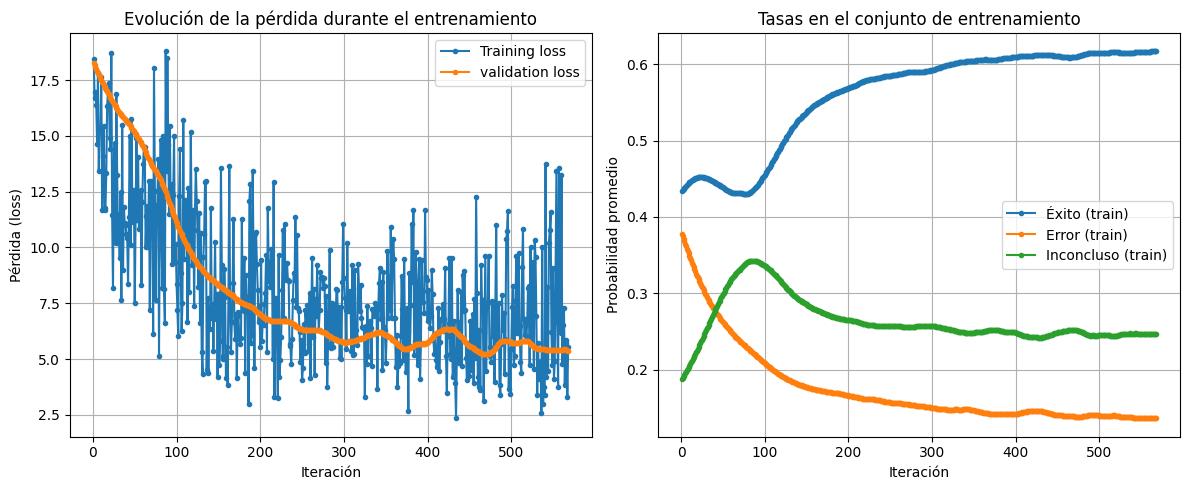

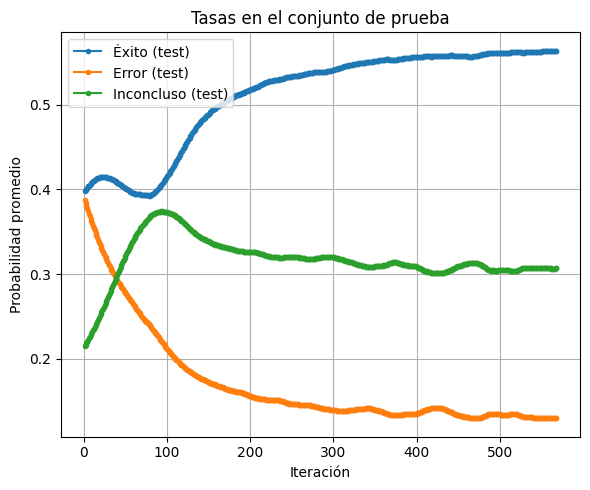

In [13]:
# Visualización de los resultados
plt.figure(figsize=(12,5))

# Evolución de la pérdida
plt.subplot(1,2,1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss")
plt.plot(range(1, it+1), val_loss_history, '.-', label="validation loss")
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la pérdida durante el entrenamiento")
plt.grid()
plt.legend()

# Éxito, Error e Inconcluso en train
plt.subplot(1,2,2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito (train)")
plt.plot(range(1, it+1), train_err_history, '.-', label="Error (train)")
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso (train)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de entrenamiento")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Figura para test
plt.figure(figsize=(6,5))

# Éxito, Error e Inconcluso en test
plt.plot(range(1, it+1), test_suc_history, '.-', label="Éxito (test)")
plt.plot(range(1, it+1), test_err_history, '.-', label="Error (test)")
plt.plot(range(1, it+1), test_inc_history, '.-', label="Inconcluso (test)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de prueba")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

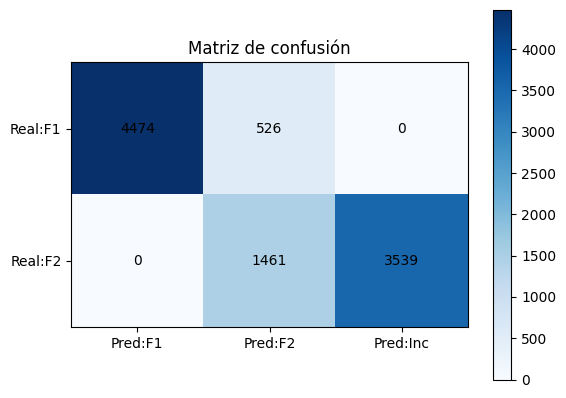

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
